In [ ]:
import numpy as np
import pandas as pd
import time

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Scikit-learn: Model Selection and Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Scikit-learn: Preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

# Scikit-learn: Pipeline and Composition
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

# Scikit-learn: Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
import xgboost as xgb

# Scikit-learn: Feature Selection
from sklearn.feature_selection import SelectFromModel

In [4]:
train_full_raw = pd.read_csv('/Users/edwina/Desktop/House_Pricing_Prediction/data/train.csv', index_col='Id')
train_full = train_full_raw.copy()

# Select Target Variable

In [5]:
target_missing = train_full['SalePrice'].isnull().sum()
print(f"Numbers of missing values for target variable: {target_missing} out of {len(train_full)} rows.")

if target_missing > 0:
    train_full.dropna(axis=0, subset=['SalePrice'], inplace=True)

y = train_full['SalePrice'].copy()
X = train_full.drop(['SalePrice'], axis=1)

Numbers of missing values for target variable: 0 out of 1460 rows.


# Preprocessing

## Break off validation set from training data

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print(f"Size of Train data = {X_train.shape, y_train.shape}")
print(f"Size of Validation data = {X_valid.shape, y_valid.shape}")

Size of Train data = ((1168, 79), (1168,))
Size of Validation data = ((292, 79), (292,))


## Seperate Columns for Different Transformers

In [7]:
raw_cat_cols = X.select_dtypes(include='object').columns.tolist()
raw_num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

exception_cols = ['Id']
quality_cols = ['PoolQC', 'FireplaceQu', 'MasVnrType']
presence_cols = ['Fence', 'Alley', 'MiscFeature']
high_cardinality_col = ['Neighborhood', 'Exterior2nd', 'Exterior1st']
exclude_cols = set(exception_cols + quality_cols + presence_cols + high_cardinality_col)

remain_categorical_cols = [col for col in raw_cat_cols if col not in exclude_cols]
remain_numerical_cols = [col for col in raw_num_cols if col not in exclude_cols]

## Designed Transformers (Based on EDA)

### Features with Quality Levels Transformer 

- Apply Imputation + Ordinal Encoding + Binary Indicator (HasPool, HasMasonryVeneer, HasFireplace)

- Used for features of `PoolQC`, `MasVnrType`, `FireplaceQu`

In [8]:
CATEGORY_ORDER = {
    'PoolQC': ['None', 'Fa', 'Gd', 'Ex'],
    'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'MasVnrType': ['CBlock', 'BrkCmn', 'None', 'BrkC', 'BrkFace', 'Stone']
}

class QualityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, category_order_dict = CATEGORY_ORDER):
        self.columns = columns
        self.category_order_dict = category_order_dict
        self.encoders = {}

    def fit(self, X, y=None):
        for col in self.columns:
            if col in X.columns:
                categories = [self.category_order_dict[col]]
                oe = OrdinalEncoder(
                    categories=categories,
                    handle_unknown="use_encoded_value",
                    unknown_value=-1,
                )
                oe.fit(X[[col]].fillna("None"))
                self.encoders[col] = oe
            else:
                print(f"Warning： {col} does not exist in the DataFrame. Skipping this column.")
        return self

    def transform(self, X):
        X_ = X.copy()

        for col in self.columns:
            if col in self.encoders:
                col_filled = X_[[col]].fillna("None")

                # Ordinal Encoding
                encoded = self.encoders[col].transform(col_filled)
                X_[col] = encoded.flatten()

                # Binary Presence Feature
                X_[f"Has{col}"] = (col_filled.iloc[:, 0] != "None").astype(int)

        return X_.reset_index(drop=True)

    def get_feature_names_out(self, input_features=None):
        processed_cols = [col for col in self.columns if col in self.encoders]
        return np.array(processed_cols + [f"Has{col}" for col in processed_cols])


### Features with Sparse Categories Transformer 

- Apply Imputation + Binary Indicator (HasMiscFeature, HasAlley, HasFence)

- Used for features of `MiscFeature`, `Alley`, `Fence`

In [9]:
class PresenceOnlyTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        if self.columns is None:
            self.columns = list(X.columns)
        return self

    def transform(self, X):
        X_ = X.copy()
        for col in self.columns:
            if col in X_.columns:
                col_filled = X_[col].fillna("None")
                X_[f"Has{col}"] = (col_filled != "None").astype(int)

        existing_has_cols = [f"Has{col}" for col in self.columns if col in X.columns]
        return X_[existing_has_cols]

    def get_feature_names_out(self, input_features=None):
        return np.array([f"Has{col}" for col in self.columns])

### Frequency Encode Transformer for High Cardinality Features

- Used for features of `Neighborhood`, `Exterior2nd`, `Exterior1st`

In [10]:
class FrequencyEncodeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.freq_maps = {}

    def fit(self, X, y=None):
        if self.columns is None:
            self.columns = list(X.columns)
            
        for col in self.columns:
            self.freq_maps[col] = X[col].value_counts(normalize=True)
        return self

    def transform(self, X):
        X_ = X.copy()
        for col in self.columns:
            X_[col] = X_[col].map(self.freq_maps[col]).fillna(0)
        return X_[self.columns]

    def get_feature_names_out(self, input_features=None):
        return np.array(self.columns)


## Pipeline

In [ ]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())])

# Preprocessing for categorical data 
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Bundle preprocessing transformers
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, remain_numerical_cols),
    ('cat', categorical_transformer, remain_categorical_cols),
    ('quality', QualityTransformer(columns=quality_cols), quality_cols),  # 直接使用
    ('presence', PresenceOnlyTransformer(columns=presence_cols), presence_cols),  # 直接使用
    ('high_card', FrequencyEncodeTransformer(columns=high_cardinality_col), high_cardinality_col)  # 直接使用
])

In [12]:
# Test the preprocessor
X_train_transformed = preprocessor.fit_transform(X_train)
print(f"Original number of features: {X_train.shape[1]}")
print(f"Number of features after transformation: {X_train_transformed.shape[1]}")
print(f"Total number of samples: {X_train_transformed.shape[0]}")

Original number of features: 79
Number of features after transformation: 220
Total number of samples: 1168


# Base Model (Random Forest Regressor)

In [13]:
# Base Model (Fast Validation)
print("=== Base Model ===")
base_model = RandomForestRegressor(    
    n_estimators=100,          
    max_depth=5,              
    min_samples_split=30,      
    max_features=0.3,          
    random_state=42
)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', base_model)
])
model_with_log_target = TransformedTargetRegressor(
    regressor=pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)
model_with_log_target.fit(X_train, y_train)

train_preds = model_with_log_target.predict(X_train)
valid_preds = model_with_log_target.predict(X_valid)
train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

print(f"Base RF MAE - Train: {train_mae:.0f}, Valid: {valid_mae:.0f}")

=== Base Model ===
Base RF MAE - Train: 17268, Valid: 20899


# Comprehensive Model Comparison

### Functions of Model Comparison

In [14]:
# =============================================================================
# # Models and hyperparameters
# =============================================================================

def get_models():
    models = {
        'Linear Regression': {
            'model': LinearRegression(),
            'param_grid': {},
            'color': '#1f77b4' 
        },

        'Ridge': {
            'model': Ridge(random_state=42),
            'param_grid': {
                'regressor__model__max_iter': [500, 1000, 1500, 2000], 
                'regressor__model__alpha': [1.0, 10.0, 50.0, 100.0, 500.0]  
            },
            'color': "#f26c6c"
        },

        'Lasso': {
            'model': Lasso(random_state=42),
            'param_grid': {
                'regressor__model__max_iter': [500, 1000, 1500, 2000], 
                'regressor__model__alpha': [0.001, 0.01, 0.1, 0.5, 1.0] 
            },
            'color': "#dfc73f"
        },

        'Random Forest': {
            'model': RandomForestRegressor(random_state=42),
            'param_grid': {
                'regressor__model__n_estimators': [200],      
                'regressor__model__max_depth': [5, 7],           
                'regressor__model__min_samples_split': [40, 60], 
                'regressor__model__min_samples_leaf': [10, 20],     
                'regressor__model__max_features': [0.2, 0.3]
            },
            'color': "#70ab27" 
        },
        
        'XGBoost': {
            'model': xgb.XGBRegressor(random_state=42, eval_metric='rmse'),
            'param_grid': {
                'regressor__model__n_estimators': [200],      
                'regressor__model__learning_rate': [0.03],   
                'regressor__model__max_depth': [3],              
                'regressor__model__subsample': [0.7],           
                'regressor__model__colsample_bytree': [0.4],   
                'regressor__model__reg_lambda': [50.0],      
                'regressor__model__min_child_weight': [10]
            },
            'color': "#461989" 
        }
    }
    
    return models

# =============================================================================
# # Models Comparison
# =============================================================================

def model_comparison(X_train, y_train, X_valid, y_valid, preprocessor):
    print("Start to Model Comparison ...")
    
    models_info = get_models()
    results = []
    
    selected_models = list(models_info.keys())
    
    for model_name in selected_models:
        print(f"\n--- Training {model_name} ---")
        
        model_info = models_info[model_name]
        start_time = time.time()
        
        try:
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('model', model_info['model'])  # model step 要命名為 'model'
            ])
            
            model_with_log = TransformedTargetRegressor(
                    regressor=pipeline,
                    func=np.log1p,
                    inverse_func=np.expm1
                )
            
            grid_search = GridSearchCV(
                    model_with_log,
                    model_info['param_grid'],
                    cv=5,  
                    scoring='neg_mean_absolute_error',
                    n_jobs=-1
                )
                
            grid_search.fit(X_train, y_train)
            cv_score = -grid_search.best_score_

            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            
            # Predictions and evaluation
            train_preds = best_model.predict(X_train)
            valid_preds = best_model.predict(X_valid)
            
            train_mae = mean_absolute_error(y_train, train_preds)
            valid_mae = mean_absolute_error(y_valid, valid_preds)

            train_r2 = r2_score(y_train, train_preds)
            valid_r2 = r2_score(y_valid, valid_preds)
            
            gap_pct = ((valid_mae - train_mae) / train_mae) * 100
            training_time = time.time() - start_time
            
            result = {
                'Model': model_name,
                'Residuals': y_valid - valid_preds,
                'Train_MAE': train_mae,
                'Valid_MAE': valid_mae,
                'Train_R2': train_r2,
                'Valid_R2': valid_r2,
                'Overfitting_Gap_%': gap_pct,
                'CV_MAE': cv_score,
                'Training_Time_s': training_time,
                'Best_Params': best_params,
                'Best_Model': best_model,
                'color': model_info['color'],
                'Numbers_of_features': preprocessor.transform(X_train).shape[1]
            }
            
            results.append(result)
            
            print(f"✅ {model_name} Finisihed Training") 
            print(f"   Param grid: {best_params}")
            print(f"   Valid MAE: {valid_mae:.0f}")
            print(f"   Valid R²: {valid_r2:.3f}")
            print(f"   Time: {training_time:.1f}s")
            
        except Exception as e:
            print(f"❌ {model_name} 失敗: {str(e)}")
            continue
    
    return results, models_info

# =============================================================================
# Analyze Model Results
# =============================================================================

def analyze_model_results(results):    
    print(f"\n" + "="*80)
    print("📊 Model Evaluation Results")
    print("="*80)
    
    df_results = pd.DataFrame(results)
    df_results = df_results.sort_values('Valid_MAE')
    
    # Add score based on validation MAE and overfitting gap
    df_results['Score'] = df_results['Valid_MAE'] * (1 + df_results['Overfitting_Gap_%'] / 100)

    # Find the best model based on Score
    best_model_idx = df_results['Score'].idxmin()
    best_model_name = df_results.loc[best_model_idx, 'Model']
    best_mae = df_results.loc[best_model_idx, 'Valid_MAE']
    best_r2 = df_results.loc[best_model_idx, 'Valid_R2']

    best_result = results[best_model_idx]
    best_estimator = best_result['Best_Model']
    best_params = best_result['Best_Params']
    
    print(f"\n🎯 最佳模型: {best_model_name}")
    print(f"   MAE: {best_mae:.0f}")
    print(f"   R²: {best_r2:.3f}")

    return df_results, best_estimator, best_params


### Functions of Visualize Model Results

In [24]:
def create_comparison_plots(df_results):
    colors = df_results['color'].tolist()
    
    fig = make_subplots(
       rows=2, cols=2,
       subplot_titles=('Validation MAE Comparison', 'Validation R² Comparison', 
                      'Overfitting Analysis', 'Performance vs Training Time'),
       specs=[[{"secondary_y": False}, {"secondary_y": False}],
              [{"secondary_y": False}, {"secondary_y": False}]]
   )

    # 1. MAE Comparison
    fig.add_trace(
        go.Bar(x=df_results['Model'], y=df_results['Valid_MAE'], 
                marker_color=colors, name='Valid MAE', showlegend=False),
        row=1, col=1
    )
    
    # 2. R² Comparison
    fig.add_trace(
        go.Bar(x=df_results['Model'], y=df_results['Valid_R2'], 
                marker_color=colors, name='Valid R²', showlegend=False),
        row=1, col=2
    )
    
    # 3. Overfitting Analysis
    fig.add_trace(
        go.Bar(x=df_results['Model'], y=df_results['Overfitting_Gap_%'], 
                marker_color=colors, name='Overfitting Gap', showlegend=False),
        row=2, col=1
    )
    
    # threshold lines for overfitting
    fig.add_hline(y=15, line_dash="dash", line_color="orange", 
                    annotation_text="Acceptable (15%)", row=2, col=1)
    fig.add_hline(y=25, line_dash="dash", line_color="red", 
                    annotation_text="Problematic (25%)", row=2, col=1)
    
    # 4. Performance vs Training Time
    fig.add_trace(
    go.Scatter(x=df_results['Training_Time_s'], y=df_results['Valid_MAE'],
               mode='markers',  # 只顯示點，不顯示文字
               marker=dict(color=colors, size=15, opacity=0.8),  # 稍微增大點的大小
               text=df_results['Model'],  # 模型名稱
               customdata=df_results[['Train_R2', 'Valid_R2', 'Overfitting_Gap_%']],  # 額外資訊
               hovertemplate='<b>%{text}</b><br>' +
                           'Training Time: %{x:.1f} seconds<br>' +
                           'Validation MAE: %{y:.0f}<br>' +
                           'Train R²: %{customdata[0]:.3f}<br>' +
                           'Valid R²: %{customdata[1]:.3f}<br>' +
                           'Overfitting Gap: %{customdata[2]:.1f}%<br>' +
                           '<extra></extra>',  # 移除預設的 trace 名稱框
               name='Models', showlegend=False),
    row=2, col=2
)
    
    fig.update_layout(
        height=1200, width=1200,
        title_text="Model Comparison Results",
        showlegend=False
    )
    
    fig.update_xaxes(title_text="Model", row=1, col=1)
    fig.update_yaxes(title_text="MAE", row=1, col=1)
    
    fig.update_xaxes(title_text="Model", row=1, col=2)
    fig.update_yaxes(title_text="R²", row=1, col=2)
    
    fig.update_xaxes(title_text="Model", row=2, col=1)
    fig.update_yaxes(title_text="Overfitting Gap (%)", row=2, col=1)
    
    fig.update_xaxes(title_text="Training Time (seconds)", row=2, col=2)
    fig.update_yaxes(title_text="Validation MAE", row=2, col=2)
    
    fig.write_image("../images/Model/model_comparison_results.png", scale=2)
    fig.show()


def plot_train_vs_valid_residuals(results, X_train, X_valid, y_train, y_valid):    
    n_models = len(results)
    fig, axes = plt.subplots(n_models, 2, figsize=(16, 4*n_models))
    
    # if only one model, reshape axes to 1 row
    if n_models == 1:
        axes = axes.reshape(1, -1)
    
    for i, result in enumerate(results):
        model_name = result['Model']
        best_model = result['Best_Model']
        
        # train and validation predictions
        train_preds = best_model.predict(X_train)
        valid_preds = best_model.predict(X_valid)
        
        # calculate residuals
        train_residuals = y_train - train_preds
        valid_residuals = y_valid - valid_preds
        
        # Left plot: Residuals distribution
        axes[i, 0].hist(train_residuals, bins=50, alpha=0.7, label='Train', density=True, color='blue')
        axes[i, 0].hist(valid_residuals, bins=50, alpha=0.7, label='Valid', density=True, color='red')
        axes[i, 0].axvline(0, color='black', linestyle='--', alpha=0.8)
        axes[i, 0].set_title(f'{model_name}: Residual Distribution')
        axes[i, 0].set_xlabel('Residuals')
        axes[i, 0].set_ylabel('Density')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)
        
        train_std = np.std(train_residuals)
        valid_std = np.std(valid_residuals)
        train_mean = np.mean(train_residuals)
        valid_mean = np.mean(valid_residuals)
        
        axes[i, 0].text(0.02, 0.95, 
                       f'Train: μ={train_mean:.0f}, σ={train_std:.0f}\nValid: μ={valid_mean:.0f}, σ={valid_std:.0f}', 
                       transform=axes[i, 0].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Right plot: Predicted vs Actual
        min_val = min(y_train.min(), y_valid.min(), train_preds.min(), valid_preds.min())
        max_val = max(y_train.max(), y_valid.max(), train_preds.max(), valid_preds.max())
        
        axes[i, 1].scatter(y_train, train_preds, alpha=0.6, label='Train', color='blue', s=20)
        axes[i, 1].scatter(y_valid, valid_preds, alpha=0.6, label='Valid', color='red', s=20)
        axes[i, 1].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, label='Perfect Prediction')
        axes[i, 1].set_title(f'{model_name}: Predicted vs Actual')
        axes[i, 1].set_xlabel('Actual Values')
        axes[i, 1].set_ylabel('Predicted Values')
        axes[i, 1].legend()
        axes[i, 1].grid(True, alpha=0.3)
        
        train_r2 = result['Train_R2']
        valid_r2 = result['Valid_R2']
        axes[i, 1].text(0.02, 0.95, 
                       f'Train R²: {train_r2:.3f}\nValid R²: {valid_r2:.3f}', 
                       transform=axes[i, 1].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    fig.tight_layout()
    fig.savefig("../images/Model/residuals_vs_predicted_comparison_across_models.png")
    
    import os
    from datetime import datetime

    print(f"Last modified time: {datetime.fromtimestamp(os.path.getmtime('../images/Model/residuals_vs_predicted_comparison_across_models.png'))}")

    fig.show()

In [16]:
# Model Comparison and Analysis
results, models_info = model_comparison(X_train, y_train, X_valid, y_valid, preprocessor)
df_results, best_estimator, best_params = analyze_model_results(results)

Start to Model Comparison ...

--- Training Linear Regression ---
✅ Linear Regression Finisihed Training
   Param grid: {}
   Valid MAE: 16333
   Valid R²: 0.920
   Time: 2.8s

--- Training Ridge ---
✅ Ridge Finisihed Training
   Param grid: {'regressor__model__alpha': 50.0, 'regressor__model__max_iter': 500}
   Valid MAE: 17585
   Valid R²: 0.904
   Time: 1.7s

--- Training Lasso ---
✅ Lasso Finisihed Training
   Param grid: {'regressor__model__alpha': 0.001, 'regressor__model__max_iter': 500}
   Valid MAE: 17139
   Valid R²: 0.912
   Time: 1.1s

--- Training Random Forest ---
✅ Random Forest Finisihed Training
   Param grid: {'regressor__model__max_depth': 7, 'regressor__model__max_features': 0.3, 'regressor__model__min_samples_leaf': 10, 'regressor__model__min_samples_split': 40, 'regressor__model__n_estimators': 200}
   Valid MAE: 20022
   Valid R²: 0.812
   Time: 5.3s

--- Training XGBoost ---
✅ XGBoost Finisihed Training
   Param grid: {'regressor__model__colsample_bytree': 0.4, 

In [33]:
df_results.to_csv("/Users/edwina/Desktop/House_Pricing_Prediction/app/dataframes/df_results.csv", index=False)

Last modified time: 2025-06-26 16:47:01.241800


/var/folders/lm/_qpcl74n0332d3zmtt5tkjw00000gn/T/ipykernel_15450/2640714515.py:147: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



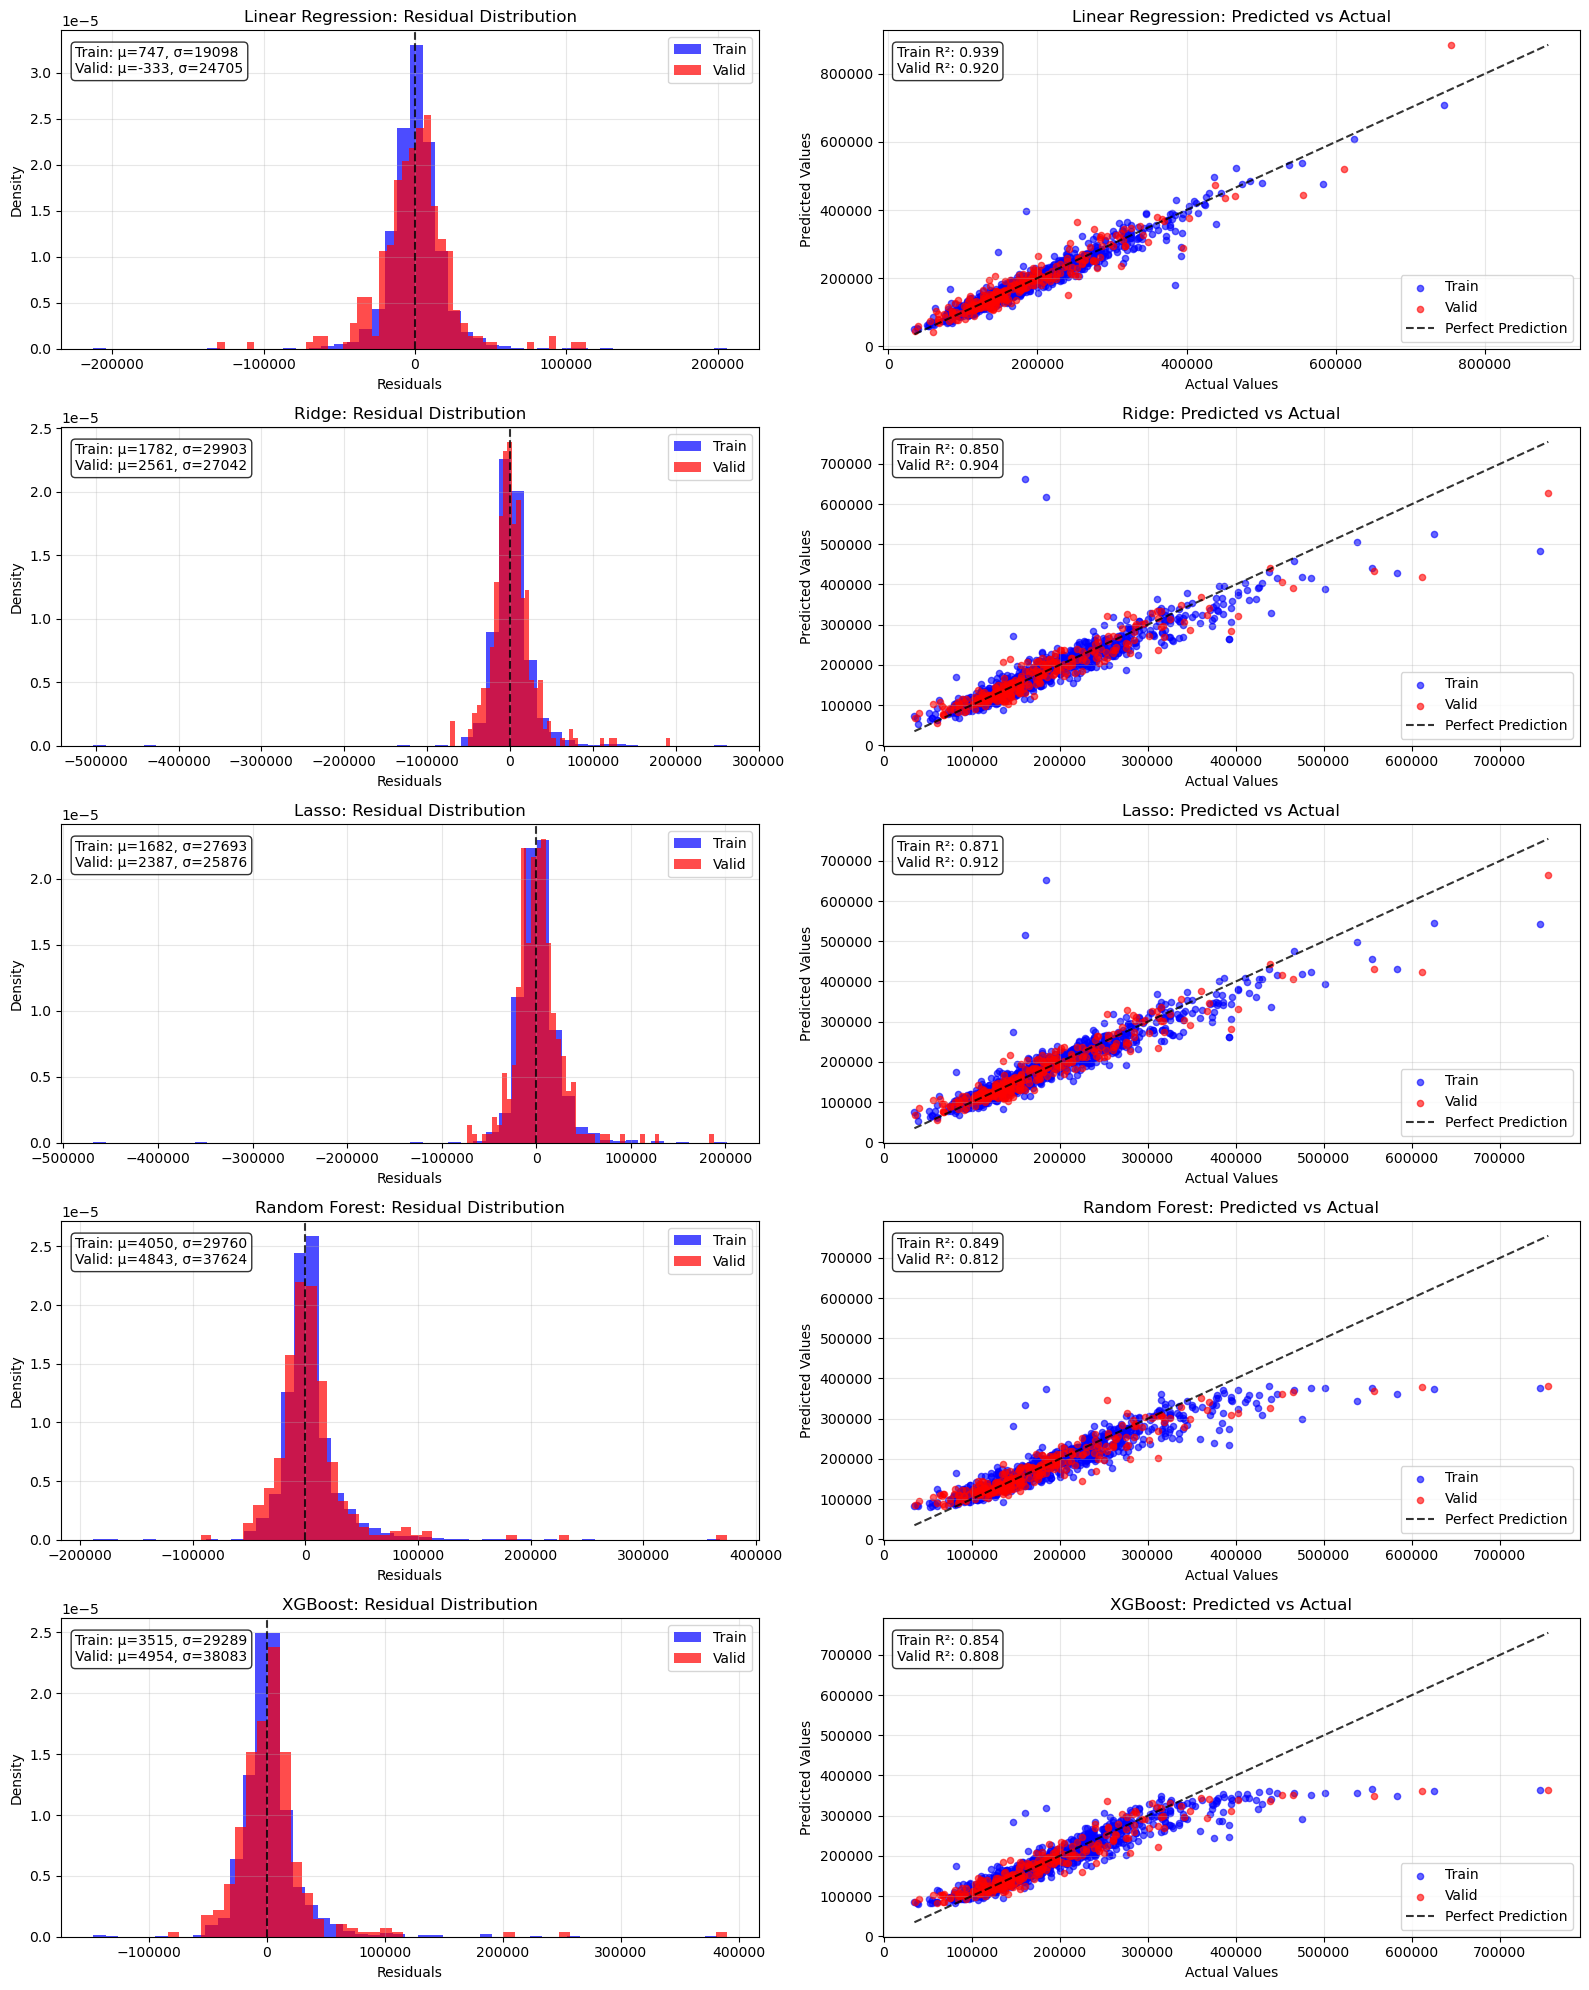

Exception ignored in: <function ResourceTracker.__del__ at 0x1023ba200>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/house_pricing/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/anaconda3/envs/house_pricing/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/anaconda3/envs/house_pricing/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107bc6200>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/house_pricing/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/anaconda3/envs/house_pricing/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/anaconda3/envs/house_pricing/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child 

In [25]:
# Visualize the results
create_comparison_plots(df_results)
plot_train_vs_valid_residuals(results, X_train, X_valid, y_train, y_valid)

## 📊 Model Comparison Summary & Insights

#### 🔍 Model Selection Criteria: Balance Between Accuracy (MAE) and Generalization (Overfitting Gap)
- Although Linear Regression achieved the lowest Validation MAE (16,333) and highest R² (0.920), its overfitting gap exceeded 36%, indicating weak generalization to unseen data. Thus, it is not considered the best model overall.

- Applied a weighted metric MAE * (1 + Overfitting Gap%) to evaluate models comprehensively — rewarding models that are both accurate and robust.

#### ✅ Lasso Regression Emerges as the Best Model
- It achieved a competitive MAE with a low overfitting gap (~12%), showing a good balance of accuracy and stability.

- Lasso’s built-in feature selection also helps simplify the model and reduce variance, making it ideal in this scenario.

#### ✅ Linear Models Outperform Nonlinear Models (RF / XGBoost)
- All linear models (Linear, Ridge, Lasso) demonstrated lower validation errors and higher R² scores.

- This suggests that the dataset likely exhibits linear relationships, and more complex models such as Random Forest or XGBoost did not yield better performance.

- Tree-based models may also be disadvantaged here due to limited sample size (~1,460 rows) — boosting models typically require larger datasets to be effective.

#### ⚠️ All Models Struggled with High-Price Properties
- Residual plots show greater spread in predictions for high-priced houses, indicating that these cases have high variance and are harder to model accurately.

- Future Work: Improve predictive for luxuery houses.

# Feature Selection
Using Lasso for embedded feature selection to reduce feature dimensionality, which helped mitigate overfitting and improved the model's generalizability.

In [18]:
best_estimator.regressor_.named_steps['model']

Lasso(alpha=0.001, max_iter=500, random_state=42)

### Function of Feature Seleciton

In [19]:
def feature_selection(best_estimator):
    print("\n=== Feature Selection Analysis ===")
    
    lasso_linear_model = best_estimator.regressor_.named_steps['model']
    coefficients = lasso_linear_model.coef_
    
    selected_features = np.where(coefficients != 0)[0]
    features_removed = len(coefficients) - len(selected_features)
    reduction_ratio = len(coefficients) / len(selected_features)

    print(f"Model: {type(lasso_linear_model).__name__}")
    print(f"Selected Features by Lasso: {len(selected_features)} / {len(coefficients)} ({len(selected_features)/220*100:.1f}%)")  
    print(f"Model Simplification: Removed {features_removed} features → {reduction_ratio:.1f}x compression")    
    return selected_features, lasso_linear_model

def feature_selection_performance(selected_features, best_estimator, lasso_linear_model, df_results, 
                             preprocessor, X_train, y_train, X_valid, y_valid):
    print("\n=== Model Performance After Feature Selection ===") 

    # Create pipeline with feature selection
    lasso = best_estimator.regressor_.named_steps['model']
    feature_selector = SelectFromModel(lasso_linear_model, prefit=False)
    
    production_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', feature_selector),
        ('model', lasso)  
    ])

    final_pipeline = TransformedTargetRegressor(
        regressor=production_pipeline,
        func=np.log1p,
        inverse_func=np.expm1
    )
    
    final_pipeline.fit(X_train, y_train)
    
    # Prediction and Compare with original Lasso mae, R²
    selected_y_valid_pred = final_pipeline.predict(X_valid)
    selected_r2 = final_pipeline.score(X_valid, y_valid)
    selected_mae = mean_absolute_error(y_valid, selected_y_valid_pred)

    original_r2 = df_results[df_results['Model'] == 'Lasso']['Valid_R2'].values[0]
    original_mae = df_results[df_results['Model'] == 'Lasso']['Valid_MAE'].values[0]

    retention = selected_r2 / original_r2 * 100
    score_change = selected_r2 - original_r2

    # Feature selection stats
    original_features_count = df_results[df_results['Model'] == 'Lasso']['Numbers_of_features'].values[0]
    selected_count = len(selected_features)
    features_removed = original_features_count - selected_count

    performance_retention = selected_r2 / original_r2 * 100
    score_change = selected_r2 - original_r2

    print(f"R² Before Feature Selection: {original_r2:.4f}")
    print(f"R² After Feature Selection:  {selected_r2:.4f}")
    print(f"Performance Retention: {retention:.1f}%")
    print(f"Score Change: {score_change:+.4f}")

    print(f"\nMAE Before Selection: {original_mae:.2f}")
    print(f"MAE After Selection: {selected_mae:.2f}")
    print(f"MAE Reduction: {original_mae - selected_mae:.2f}")
    
    final_model_info = {
        'original_r2': original_r2,
        'selected_r2': selected_r2,
        'original_mae': original_mae,
        'selected_mae': selected_mae,
        'score_change': score_change,
        'performance_retention': performance_retention,
        'features_removed': features_removed,
        'pipeline': final_pipeline
    }

    return final_model_info

### Function of Visualization of Feature Selection

In [20]:
def plot_before_after_performance(final_model_info):
        fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("MAE Before vs After", "R² Before vs After")
    )

        # MAE Plot
        fig.add_trace(
            go.Bar(
                x=["Before", "After"],
                y=[final_model_info['original_mae'], final_model_info['selected_mae']],
                marker_color=["#8ecae6", "#219ebc"],
                text=[f"{final_model_info['original_mae']:.0f}", f"{final_model_info['selected_mae']:.0f}"],
                textposition="auto",
                name="MAE"
            ),
            row=1, col=1
        )

        # R² Plot
        fig.add_trace(
            go.Bar(
                x=["Before", "After"],
                y=[final_model_info['original_r2'], final_model_info['selected_r2']],
                marker_color=["#ffb703", "#fb8500"],
                text=[f"{final_model_info['original_r2']:.4f}", f"{final_model_info['selected_r2']:.4f}"],
                textposition="auto",
                name="R²"
            ),
            row=1, col=2
        )

        fig.update_layout(
            height=500, width=1000,
            title_text="Model Performance Before vs After Feature Selection",
            showlegend=False
        )

        fig.update_yaxes(title_text="MAE", row=1, col=1)
        fig.update_yaxes(title_text="R²", row=1, col=2)

        fig.write_image("../images/Model/model_performance_before_after_feature_selection.png", scale=2)
        fig.show()


def plot_top_features(lasso_linear_model, top_n, feature_names=None):
    print(f"\n=== Top {top_n} Feature Importance Visualization ===")
    
    coefficients = lasso_linear_model.coef_
    selected_indices = np.where(coefficients != 0)[0]
    selected_coefs = coefficients[selected_indices]
    
    importance_order = np.argsort(-np.abs(selected_coefs))
    top_indices = importance_order[:top_n]
    top_coefs = selected_coefs[top_indices]
    
    if feature_names is not None:
        try:
            top_feature_names = [feature_names[selected_indices[idx]] for idx in top_indices]
        except IndexError:
            top_feature_names = [f'Feature_{selected_indices[idx]}' for idx in top_indices]
    else:
        top_feature_names = [f'Feature_{selected_indices[idx]}' for idx in top_indices]
    
    colors = ['steelblue' if coef > 0 else 'lightcoral' for coef in top_coefs]
    
    fig = go.Figure()
    
    fig.add_trace(go.Bar(
        y=top_feature_names,
        x=top_coefs,
        orientation='h',
        marker=dict(
            color=colors,
            opacity=0.7,
            line=dict(color='black', width=0.5)
        ),
        text=[f'{coef:.3f}' for coef in top_coefs],
        textposition='outside',
        textfont=dict(size=10),
        hovertemplate='<b>%{y}</b><br>' +
                      'Coefficient: %{x:.4f}<br>' +
                      '<extra></extra>',
        showlegend=False
    ))
    
    fig.add_vline(x=0, line_dash="solid", line_color="black", 
                  opacity=0.3, line_width=1)
    
    fig.update_layout(
        title=dict(
            text=f'Top {top_n} Features',
            font=dict(size=16, family="Arial Black"),
            xanchor='center',
            x = 0.5
        ),
        xaxis=dict(
            title='Lasso Coefficient',
            tickfont=dict(size=12),
            showgrid=True,
            gridwidth=1,
            gridcolor='rgba(128,128,128,0.3)'
        ),
        yaxis=dict(
            title='Features',
            tickfont=dict(size=10),
            autorange="reversed"  
        ),

        margin=dict(l=200, r=50, t=80, b=50),  # 調整邊距以容納長特徵名稱
        plot_bgcolor='white',
        paper_bgcolor='white'
    )
    
    fig.write_image("../images/Model/top20_features_from_lasso.png", scale=2)
    fig.show()

In [34]:
selected_features, lasso_linear_model = feature_selection(best_estimator)

final_model_info = feature_selection_performance(
    selected_features,      
    best_estimator,         
    lasso_linear_model,          
    df_results,            
    preprocessor,          
    X_train, y_train, X_valid, y_valid
)


=== Feature Selection Analysis ===
Model: Lasso
Selected Features by Lasso: 76 / 220 (34.5%)
Model Simplification: Removed 144 features → 2.9x compression

=== Model Performance After Feature Selection ===
R² Before Feature Selection: 0.9120
R² After Feature Selection:  0.9120
Performance Retention: 100.0%
Score Change: -0.0000

MAE Before Selection: 17139.27
MAE After Selection: 17139.19
MAE Reduction: 0.08


In [35]:
plot_before_after_performance(final_model_info)

In [38]:
import json

# 濾除無法轉為 JSON 的物件（如 pipeline）
final_model_info_json = {
    "original_r2": float(final_model_info["original_r2"]),
    "selected_r2": float(final_model_info["selected_r2"]),
    "original_mae": float(final_model_info["original_mae"]),
    "selected_mae": float(final_model_info["selected_mae"]),
    "score_change": float(final_model_info["score_change"]),
    "performance_retention": float(final_model_info["performance_retention"]),
    "features_removed": int(final_model_info["features_removed"])
}

with open("/Users/edwina/Desktop/House_Pricing_Prediction/app/data/final_model_info.json", "w") as f:
    json.dump(final_model_info_json, f, indent=4)


In [22]:
processed_feature_names = preprocessor.get_feature_names_out()
plot_top_features(lasso_linear_model, 20,  
                feature_names=processed_feature_names)


=== Top 20 Feature Importance Visualization ===


In [ ]:
coef_dict = {
    "coef": lasso_linear_model.coef_.tolist(),  
    "feature_names": processed_feature_names.tolist()  
}

with open("/Users/edwina/Desktop/House_Pricing_Prediction/app/data/lasso_top_feature_info.json", "w") as f:
    json.dump(coef_dict, f)
    

## 🧠 Top 20 Features Insights from Lasso Regression
- RoofMatl_ClyTile has the largest absolute coefficient and a strong negative impact on house prices.
⟶ Homes with clay tile roofing are significantly associated with lower sale prices.
📉 This may reflect either outdated style or correlation with lower-quality neighborhoods.

- GrLivArea (Above-ground living area) and OverallQual (Overall material and finish quality) are the second and third most influential features, both showing positive effects.
⟶ Larger living space and better construction quality lead to higher house prices.

- Most numerical features (e.g., GrLivArea, GarageCars, YearBuilt) have positive coefficients, indicating that house size and recency are key drivers of value.
⟶ Newer, more spacious homes are generally priced higher.

# ✅ Final Model Summary

| Index | Value |
|------|------|
| Final Model | Lasso Regression |
| Feature Selection | Lasso + SelectFromModel |
| Features Retained | 76 / 220 (34.5%) |
| R² (Validation) | 0.9120 |
| MAE (Validation) | 17139 |
| Performance Retention | 100% |
| Compression Ratio | 2.9x |

# Test Model

In [23]:
# Read test data
test_full_raw = pd.read_csv('/Users/edwina/Desktop/House_Pricing_Prediction/data/test.csv', index_col='Id')

final_model = final_model_info['pipeline']
test_predictions = final_model.predict(test_full_raw)

submission = pd.DataFrame({
    'Id': test_full_raw.index,
    'SalePrice': test_predictions
})

print(f"Top 10 of predicitons:")
print(submission.head(10))
# submission.to_csv('submission.csv', index=False)

Top 10 of predicitons:
     Id      SalePrice
0  1461  113597.516062
1  1462  145754.535567
2  1463  171145.071338
3  1464  196892.679132
4  1465  190732.685769
5  1466  172999.940230
6  1467  189784.894818
7  1468  167246.643341
8  1469  197251.393433
9  1470  118329.247802
